# Multi-Class Classification

MLP neural network with multi-class classification. 

We are going to see if we can create a fully connected neural network that can classify an individual as a healthy control or as a subject diagnosed with one of 3 neuropsychiatric disorders, based on the shape (LB spectrum) of their white matter tracts.

The data set we will use contains individuals that have been diagnosed with bipolar disorder, ADHD, and schizophrenia. 

### Import the needed libraries

In [52]:
#to read in the data
import pickle
#for plotting, numbers etc.
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#for splitting the data
from sklearn.model_selection import train_test_split
#keras functions
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils, plot_model, to_categorical
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l1, l2, l1_l2

#normalize the data
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegressionCV 

## Import the data

In [4]:
# eigenvalue dictionary with entry for eact tract, 600 evs per tract
allgroups_ev_dict = pickle.load(open("allgroups_ev_dict.p",'rb'))
# list of tracts we want to use
all_tracts = pickle.load(open('all_tracts.p','rb'))
# subject list
allsubjs = pickle.load(open('allsubjs.p','rb'))
# list of subject group 0 = control, 1 = adhd, 2 = bipolar, 3 = schizophrenia
groupid = pickle.load(open('groupid.p','rb'))

Since this is a different dataset, let's take a look at the data.

In [5]:
print len(all_tracts)
all_tracts[0:5]

20


[u'Callosum_Forceps_Major_surf',
 u'Callosum_Forceps_Minor_surf',
 u'Left_Arcuate_surf',
 u'Left_Cingulum_Cingulate_surf',
 u'Left_Cingulum_Hippocampus_surf']

We only have 20 tracts for each subject.

158


(array([40.,  0.,  0., 37.,  0.,  0., 43.,  0.,  0., 38.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

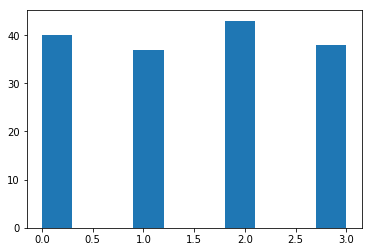

In [8]:
%matplotlib inline
print len(allsubjs)
plt.hist(groupid)

We have 158 subject in total. We have around 40 samples (individuals) in each group. The original dataset of the control group had over 100, we have randomly chosen 40 to keep the group sizes similar.

In [9]:
allgroups_ev_dict[all_tracts[0]].shape

(158, 600)

We have 600 eigenvalues per tract. 

## Preprocess the data

The eigenvalue data is already in a vector format, so we do not need to vectorize it. However, we will need to combine the vectors of all the tracts so that we have a single vector per subject.

We also need to normalize the data so that each set of eigenvalues has a mean of 0 and a standard deviation of 1. We will write a function to do this using sklearn's StandardScaler function.



### Normalize the data

In [10]:
def scale_ev_dict(ev_dict):
    scaled_dict = {}
    for tract in ev_dict.keys():
        scaler = StandardScaler()
        scaled_dict[tract] = scaler.fit_transform(ev_dict[tract])
    return scaled_dict

In [11]:
# normalize all of the tracts so that each ev is centered on 0.
allgroups_ev_dict_scaled = scale_ev_dict(allgroups_ev_dict)

### Reorganize the data

Currently the data is a dictionary of 2D matrices, we want to reorganize this into a single 2D matrix with the shape `(158, n * 20)`, where 158 is the number of subjects and n is the number of eigenvalues we are using. It is likely that 600 eigenvalues is way more than we need, but we do not know how many eigenvalues is optimal. We will write a function to do this reorganization so we can easily try multiple amounts of eigenvalues if necessary. We will start with just 200 eigenvalues for all tracts.

In [13]:
# change the organization to be one vector per subject with all evs for all tracts
def reorganize_spectrums(ev_dict_scaled, numev, HCP_subj_list=allsubjs, tractstouse=all_tracts):
    # create an empty numpy array of the shape we want
    # numev is the number of eigenvalues we want per tract
    allsubjs_alltracts_scaled = np.zeros([len(HCP_subj_list), numev*len(tractstouse)])
    for i in range(len(tractstouse)):
        allsubjs_alltracts_scaled[:, i*numev:i*numev+numev] = ev_dict_scaled[tractstouse[i]][:, 0:numev]
    return allsubjs_alltracts_scaled

In [14]:
allgroups_ev_dict_scaled_alltracts = reorganize_spectrums(allgroups_ev_dict_scaled, 200)

In [19]:
allgroups_ev_dict_scaled_alltracts.shape

(158, 4000)

### One hot encode the labels

Right now the labels are integers, we need to change them so they are one-hot encoded. This time we will use Keras bult-in function.

In [15]:
print groupid[0:5]

[0, 0, 0, 0, 0]


In [16]:
groupid_one = to_categorical(groupid)

In [17]:
print groupid_one[0:5]

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


### Check datatype

In [20]:
groupid_one = groupid_one.astype('float32')
allgroups_ev_dict_scaled_alltracts = allgroups_ev_dict_scaled_alltracts.astype('float32')

### Split the data

This is a *very* small dataset, so it will likely not do well if we split the data into the three training/validation/testing sets. Since the dataset is so small and we are not even sure if a neural network will work, we are going to just split the data into two sets, a training set and a validation set. 

In [37]:
X = allgroups_ev_dict_scaled_alltracts
Y = groupid_one

#first split the training/validation data from the testing data
trainX, testX, trainY, testY = train_test_split(X, Y, train_size  = .8, test_size = .2, random_state=0)

print len(trainX) 
print len(testX)

126
32


In [38]:
#print the sum of each column in the one hot encoded labels
np.sum(testY, axis=0)

array([7., 9., 8., 8.], dtype=float32)

It is important to note that the train_test_split function will shuffle the data for you. In the testing dataset we have a fairly even distribution of classes.

We now have a training set and a validation set of data and we are ready to try classification with a MLP. Given that we have 4 categories of labels and roughly even amounts of samples for each label, by chance we should get ~25% correct. Out goal is to get a classification accuracy higher than chance. 

## Set up the MLP

We are going to try a basic MLP. This will be the same model architecture we started with for the binary MLP, however, the last Dense layer will have 4 nodes (1 per category) and use the softmax activation function. We will also use the categorical_crossentropy loss function.

In [32]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training','Validation'])
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training','Validation'])
    plt.show()

In [39]:
model = Sequential()
model.add(Dense(64, input_dim=allgroups_ev_dict_scaled_alltracts.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs = 20, batch_size = 1, validation_data=(testX, testY))


Train on 126 samples, validate on 32 samples
Epoch 1/20
126/126 [==============================] - 1s 9ms/step - loss: 5.1247 - acc: 0.2222 - val_loss: 2.0869 - val_acc: 0.3438
Epoch 2/20
126/126 [==============================] - 0s 4ms/step - loss: 5.3955 - acc: 0.3175 - val_loss: 2.9432 - val_acc: 0.4062
Epoch 3/20
126/126 [==============================] - 0s 4ms/step - loss: 5.9486 - acc: 0.3175 - val_loss: 3.1012 - val_acc: 0.2812
Epoch 4/20
126/126 [==============================] - 0s 4ms/step - loss: 5.5678 - acc: 0.3571 - val_loss: 4.3795 - val_acc: 0.2812
Epoch 5/20
126/126 [==============================] - 0s 4ms/step - loss: 5.5655 - acc: 0.3571 - val_loss: 3.9627 - val_acc: 0.2812
Epoch 6/20
126/126 [==============================] - 0s 4ms/step - loss: 6.1992 - acc: 0.3651 - val_loss: 5.4928 - val_acc: 0.2188
Epoch 7/20
126/126 [==============================] - 0s 4ms/step - loss: 6.0736 - acc: 0.4444 - val_loss: 5.4960 - val_acc: 0.1875
Epoch 8/20
126/126 [===========

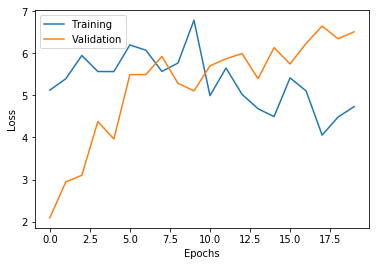

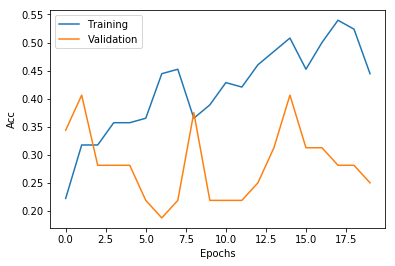

In [40]:
plot_history(history)

The highest accuracy obtained with a basic MLP was 40%, higher than chance. We can see that the model overfit very quickly, right after the 40% accuracy epoch. Let's add in some measures to prevent overfitting. We already have a few dropout layers, so we can adjust the learning rate of the optimizer (and also change the optimizer) and we can add in regularization.

In [57]:
# hidden_units = 64
# dropout_prop = 0.5
# optim = 'rmsprop'
# epochs = 20
# batch = 20
# reg=l1(0.01)
# plot=True
def make_model(hidden_units, dropout_prop, optim, epochs, batch, reg, plot=False):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=allgroups_ev_dict_scaled_alltracts.shape[1], activation='relu', kernel_regularizer=reg))
    model.add(Dropout(dropout_prop))
    model.add(Dense(hidden_units, activation='relu',kernel_regularizer=reg))
    model.add(Dropout(dropout_prop))
    model.add(Dense(4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optim,
                  metrics=['accuracy'])

    history = model.fit(trainX, trainY, epochs = epochs, batch_size = batch, validation_data=(testX, testY))
    if plot:
        plot_history(history)
    return model

Train on 126 samples, validate on 32 samples
Epoch 1/20
126/126 [==============================] - 2s 13ms/step - loss: 14.7580 - acc: 0.2778 - val_loss: 14.2162 - val_acc: 0.3125
Epoch 2/20
126/126 [==============================] - 1s 5ms/step - loss: 15.5522 - acc: 0.4048 - val_loss: 15.3481 - val_acc: 0.3125
Epoch 3/20
126/126 [==============================] - 1s 5ms/step - loss: 15.5228 - acc: 0.4206 - val_loss: 15.5295 - val_acc: 0.4375
Epoch 4/20
126/126 [==============================] - 1s 5ms/step - loss: 15.3043 - acc: 0.4365 - val_loss: 14.0399 - val_acc: 0.2500
Epoch 5/20
126/126 [==============================] - 1s 5ms/step - loss: 15.0465 - acc: 0.4206 - val_loss: 13.9405 - val_acc: 0.3438
Epoch 6/20
126/126 [==============================] - 1s 5ms/step - loss: 15.4236 - acc: 0.3254 - val_loss: 12.8134 - val_acc: 0.4062
Epoch 7/20
126/126 [==============================] - 1s 5ms/step - loss: 14.5549 - acc: 0.3730 - val_loss: 14.1200 - val_acc: 0.2188
Epoch 8/20
126/1

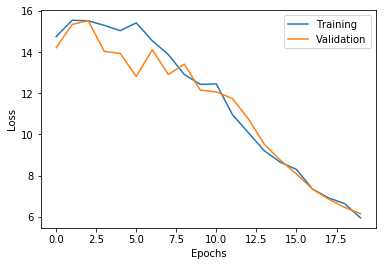

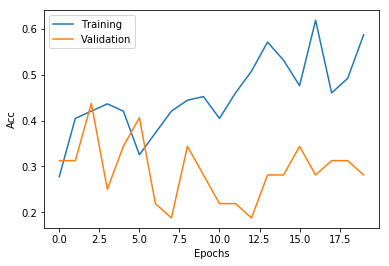

In [72]:
hidden_units = 100
dropout_prop = 0.5
optim = Adam(lr=0.001)
epochs = 20
batch = 1
reg=l1_l2(0.001)
plot=True
make_model(hidden_units, dropout_prop, optim, epochs, batch, reg, plot)

Train on 126 samples, validate on 32 samples
Epoch 1/20
126/126 [==============================] - 2s 14ms/step - loss: 12.2837 - acc: 0.2302 - val_loss: 9.6595 - val_acc: 0.4375
Epoch 2/20
126/126 [==============================] - 1s 4ms/step - loss: 11.7741 - acc: 0.3333 - val_loss: 9.5037 - val_acc: 0.3125
Epoch 3/20
126/126 [==============================] - 1s 4ms/step - loss: 10.8829 - acc: 0.3571 - val_loss: 8.0491 - val_acc: 0.4062
Epoch 4/20
126/126 [==============================] - 1s 4ms/step - loss: 9.0308 - acc: 0.4444 - val_loss: 9.1445 - val_acc: 0.2188
Epoch 5/20
126/126 [==============================] - 1s 4ms/step - loss: 9.3854 - acc: 0.3413 - val_loss: 8.7543 - val_acc: 0.1875
Epoch 6/20
126/126 [==============================] - 1s 4ms/step - loss: 8.0528 - acc: 0.4206 - val_loss: 7.6358 - val_acc: 0.3438
Epoch 7/20
126/126 [==============================] - 1s 4ms/step - loss: 8.0372 - acc: 0.4048 - val_loss: 7.5056 - val_acc: 0.3125
Epoch 8/20
126/126 [=======

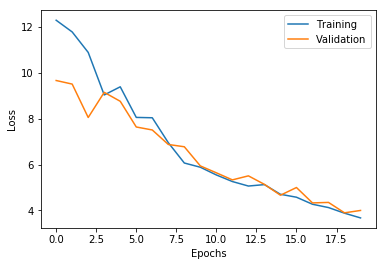

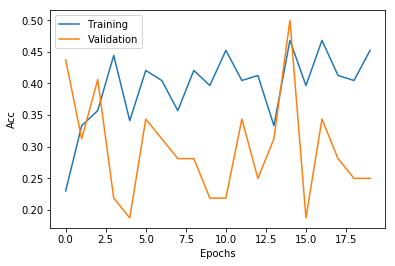

In [77]:
hidden_units = 100
dropout_prop = 0.5
optim = RMSprop(lr=0.001)
epochs = 20
batch = 1
reg=l1_l2(0.001)
plot=True
make_model(hidden_units, dropout_prop, optim, epochs, batch, reg, plot)

Train on 126 samples, validate on 32 samples
Epoch 1/20
126/126 [==============================] - 2s 15ms/step - loss: 4.0029 - acc: 0.2698 - val_loss: 2.5524 - val_acc: 0.2500
Epoch 2/20
126/126 [==============================] - 1s 4ms/step - loss: 4.7955 - acc: 0.2381 - val_loss: 2.5587 - val_acc: 0.2812
Epoch 3/20
126/126 [==============================] - 1s 4ms/step - loss: 4.9065 - acc: 0.3016 - val_loss: 2.7255 - val_acc: 0.3125
Epoch 4/20
126/126 [==============================] - 1s 4ms/step - loss: 5.2799 - acc: 0.2540 - val_loss: 2.4430 - val_acc: 0.2812
Epoch 5/20
126/126 [==============================] - 1s 4ms/step - loss: 4.4975 - acc: 0.2698 - val_loss: 2.4199 - val_acc: 0.2500
Epoch 6/20
126/126 [==============================] - 1s 4ms/step - loss: 3.7395 - acc: 0.3651 - val_loss: 1.9190 - val_acc: 0.3438
Epoch 7/20
126/126 [==============================] - 1s 4ms/step - loss: 3.5115 - acc: 0.4286 - val_loss: 2.7554 - val_acc: 0.3125
Epoch 8/20
126/126 [==========

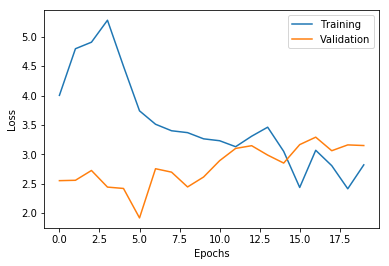

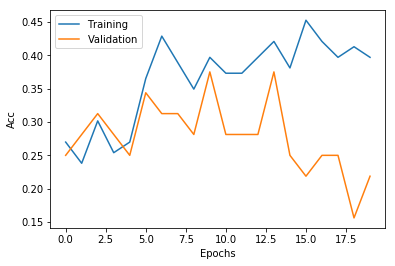

In [83]:
hidden_units = 20
dropout_prop = 0.5
optim = RMSprop(lr=0.001)
epochs = 20
batch = 1
reg=l1_l2(0.001)
plot=True
make_model(hidden_units, dropout_prop, optim, epochs, batch, reg, plot)

Train on 126 samples, validate on 32 samples
Epoch 1/10
126/126 [==============================] - 3s 20ms/step - loss: 10.3446 - acc: 0.2778 - val_loss: 6.5530 - val_acc: 0.3125
Epoch 2/10
126/126 [==============================] - 1s 5ms/step - loss: 9.4264 - acc: 0.2222 - val_loss: 5.3998 - val_acc: 0.5000
Epoch 3/10
126/126 [==============================] - 1s 5ms/step - loss: 7.7544 - acc: 0.2222 - val_loss: 5.0314 - val_acc: 0.2188
Epoch 4/10
126/126 [==============================] - 1s 5ms/step - loss: 6.8118 - acc: 0.2460 - val_loss: 4.1133 - val_acc: 0.3438
Epoch 5/10
126/126 [==============================] - 1s 5ms/step - loss: 5.4372 - acc: 0.2222 - val_loss: 3.6148 - val_acc: 0.2500
Epoch 6/10
126/126 [==============================] - 1s 5ms/step - loss: 3.8610 - acc: 0.3016 - val_loss: 3.0876 - val_acc: 0.2812
Epoch 7/10
126/126 [==============================] - 1s 5ms/step - loss: 3.3503 - acc: 0.2698 - val_loss: 2.7063 - val_acc: 0.2500
Epoch 8/10
126/126 [=========

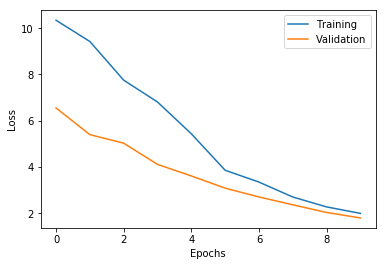

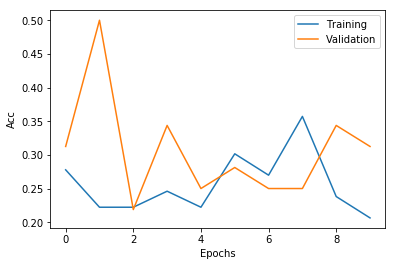

In [95]:
model = Sequential()
model.add(Dense(64, input_dim=allgroups_ev_dict_scaled_alltracts.shape[1], activation='relu', kernel_regularizer=l1_l2(0.001)))
model.add(Dropout(0.7))
model.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(0.001)))
model.add(Dropout(0.7))
model.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(0.001)))
model.add(Dropout(0.7))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs = 10, batch_size = 1, validation_data=(testX, testY))
plot_history(history)